In [3]:
# magic command to reload modules
%load_ext autoreload
%autoreload 2

In [4]:
# append sys.path
import pickle
import sys
sys.path.append('../src')

from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

import os
from tqdm import tqdm

In [5]:
import matplotlib as mpl
# remove top and right axis from plots
mpl.rcParams["axes.spines.right"] = True
mpl.rcParams["axes.spines.top"] = True

# remove all edges
mpl.rcParams["axes.edgecolor"] = "k"
mpl.rcParams['axes.linewidth'] = 2

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}
mpl.rc('font', **font)
cmap = ['tab:blue', 'tab:red', 'tab:orange', 'tab:purple', 'tab:green']

In [6]:
!pwd

/home/wehe/tmp/NSC/codes/notebook


## Interface for prior analysis

In [66]:
import ipywidgets
from ipywidgets import interact, interactive, fixed, interact_manual
from simulator.DM_model import DM_model
from dataset.seqC_generator import seqC_generator
from dataset.model_sim_pR import get_boxUni_prior
from analysis.plot_sim_results import plot_parameters
import ipywidgets as widgets
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [67]:
# generate input sequence
seqC = seqC_generator().generate(
    dur_list=[11],
    MS_list=[0.4],
    seqC_sample_per_MS=1,
)

---
generated seqC info
dur_list: [11]
MS_list: [0.4]
seqC_sample_per_MS: 1
generated seqC shape: (1, 1, 1, 15)


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


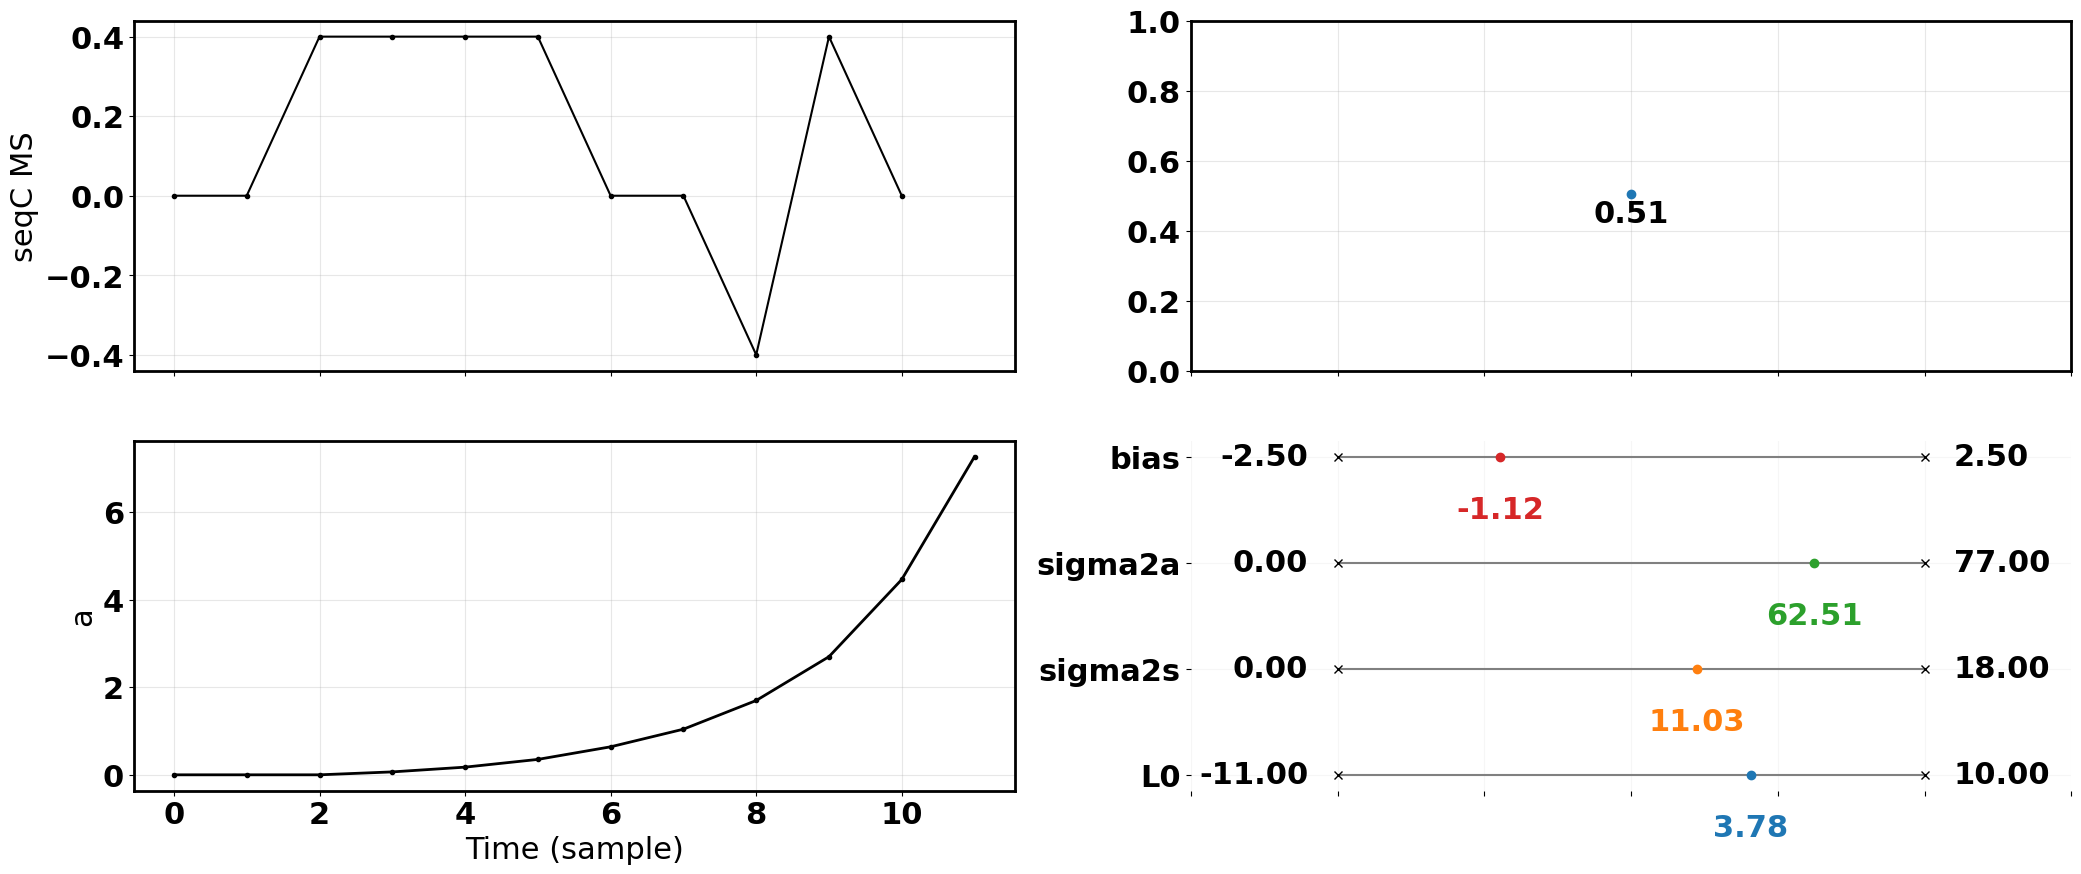

In [68]:
# generate prior parameters
model_name = 'B-G-L0S-O-N-'
prior_min = [-2.5,   0,  0, -11]
prior_max = [ 2.5,  77, 18,  10]
# prior_min = [-3.7,   0, 0,  0, -1]
# prior_max = [ 2.5,  71, 0, 18,  1]
prior = get_boxUni_prior(prior_min, prior_max)
params = prior.sample((1,))[0].tolist()
    
def plot_seqC_a_prior(model_name, prior_min, prior_max, params):
    
    model = DM_model(params=params, model_name=model_name)
    a, probR = model.simulate(seqC)

    fig, axs = plt.subplots(2, 2, sharex='col', figsize=(25, 10))

    # plot input sequence
    ax = axs[0,0]
    ax.clear()
    ax.plot(seqC[0,0,0], '.-k')
    ax.grid(alpha=0.3)
    ax.set_ylabel('seqC MS')

    # plot a mean trace
    ax = axs[1,0]
    ax = model.plot_a_mean_trace(ax, a, color='k')
    
    # plot probR
    ax = axs[0,1]
    ax.clear()
    ax.plot(0, probR, 'o')
    if probR<0.5:
        ax.text(0, probR+0.1, f'{probR:.2f}', ha='center', va='top', color='k')
    else:
        ax.text(0, probR-0.1, f'{probR:.2f}', ha='center', va='bottom', color='k')
    ax.grid(alpha=0.3)
    ax.set_xlim(-1,1)
    ax.set_ylim(0,1)

    # plot parameter values
    ax = axs[1,1]
    prior_labels = ['bias', 'sigma2a', 'sigma2s', 'L0']
    plot_parameters(ax, params, prior_min, prior_max, prior_labels=prior_labels)

plot_seqC_a_prior(model_name, prior_min, prior_max, params)

### build interface

In [71]:
# generate input sequence
seqC = seqC_generator().generate(
    dur_list=[15],
    MS_list=[0.4],
    seqC_sample_per_MS=1,
)
model_name = 'B-G-L0S-O-N-'
prior_min = [-2.5,   0,  0, -11]
prior_max = [ 2.5,  77, 18,  10]

prior = get_boxUni_prior(prior_min, prior_max)
params = prior.sample((1,))[0].cpu().numpy()

bias_slider = widgets.FloatSlider(value=0, min=prior_min[0], max=prior_max[0], step=0.1, description='bias:')
sigma2a_slider = widgets.FloatSlider(value=0, min=prior_min[1], max=prior_max[1], step=0.1, description='sigma2a:')
sigma2s_slider = widgets.FloatSlider(value=0, min=prior_min[2], max=prior_max[2], step=0.1, description='sigma2s:')
L0_slider = widgets.FloatSlider(value=0, min=prior_min[3], max=prior_max[3], step=0.1, description='L0:')

def update_plot(bias, sigma2a, sigma2s, L0):
    plot_seqC_a_prior(model_name=model_name, prior_min=prior_min, prior_max=prior_max, params=[bias, sigma2a, sigma2s, L0])

interactive_plot = widgets.interactive(update_plot, bias=bias_slider, sigma2a=sigma2a_slider, sigma2s=sigma2s_slider, L0=L0_slider)
display(interactive_plot)


---
generated seqC info
dur_list: [15]
MS_list: [0.4]
seqC_sample_per_MS: 1
generated seqC shape: (1, 1, 1, 15)


interactive(children=(FloatSlider(value=0.0, description='bias:', max=2.5, min=-2.5), FloatSlider(value=0.0, d…

### generate a movie

In [58]:
# seqC = seqC_generator().generate(
#     MS_list=[0.4],
#     sample_size=1,
#     single_dur=11
# )

# # generate prior parameters
# model_name = 'B-G-L0S-O-N-'
# prior_min = [-3.7,   0, 0,  0, -5]
# prior_max = [ 2.5,  71, 0, 18,  7]

# prior_step = [0.2, 1, 0, 1, 0.25]

params_collection = []
probRs_collection = []
a_collection = []

# for p_bias in tqdm(np.arange(prior_min[0], prior_max[0], prior_step[0])):
for p_bias in [0.5]:    
    # for p_sigma2a in np.arange(prior_min[1], prior_max[1], prior_step[1]):
    for p_sigma2a in [0.1]:
        for p_sigma2s in np.arange(prior_min[3], prior_max[3], prior_step[3]):
        # for p_sigma2s in [2]:
            # for p_L0 in np.arange(prior_min[4], prior_max[4], prior_step[4]):
            for p_L0 in [1]:
                params = [p_bias, p_sigma2a, 0, p_sigma2s, p_L0]
                model = DM_model(params=params, modelName=model_name)
                a, probR = model.simulate(seqC)
                params_collection.append(params)
                probRs_collection.append(probR)
                a_collection.append(a)

video_name = 'sigma2s.mp4'

0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
0


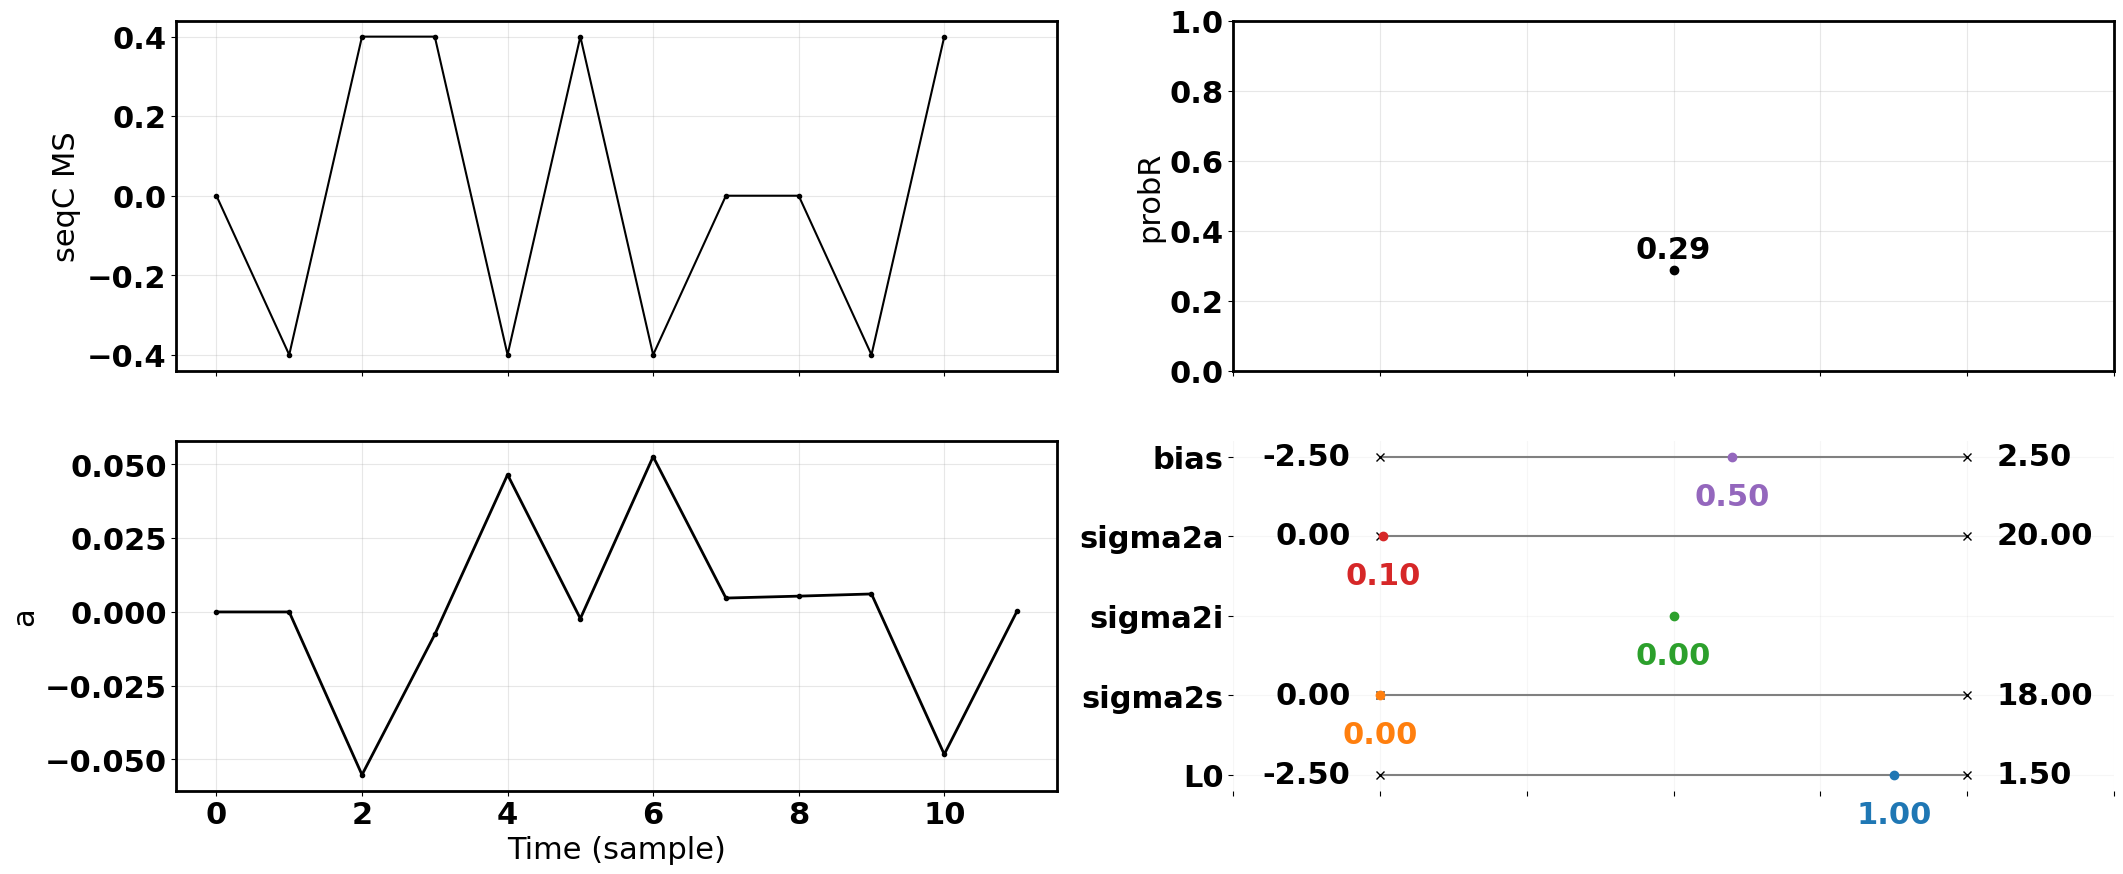

In [59]:
fig, axs = plt.subplots(2,2, sharex='col', figsize=(25, 10))

def update(frame):
    print(frame)
    ax = axs[0,0]
    ax.clear()
    ax.plot(seqC[0], '.-k')
    ax.grid(alpha=0.3)
    ax.set_ylabel('seqC MS')
    
    
    ax = axs[0,1]
    ax.clear()
    ax.plot(np.zeros(len(probRs_collection[:frame])), probRs_collection[:frame], '.', color='grey')
    ax.plot(0, probRs_collection[frame], 'o', color='k')
    if probR<0.5:
        ax.text(0, probRs_collection[frame]+0.1, f'{probRs_collection[frame]:.2f}', ha='center', va='top', color='k')
    else:
        ax.text(0, probRs_collection[frame]-0.1, f'{probRs_collection[frame]:.2f}', ha='center', va='bottom', color='k')
    ax.set_xlim(-1,1)
    ax.set_ylim(0,1)
    ax.grid(alpha=0.3)
    ax.set_ylabel('probR')
    
    # plot a mean trace
    ax = axs[1,0]
    ax.clear()
    ax = model.plot_a_mean_trace(ax, a_collection[frame], color='k')
    
    # plot parameter values
    ax = axs[1,1]
    ax.clear()
    params = params_collection[frame]
    plot_parameters(ax, params, prior_min, prior_max)
    

ani = animation.FuncAnimation(fig, update, frames=len(params_collection), interval=5)
# ani = animation.FuncAnimation(fig, update, frames=30, interval=5)
animation_location = Path('../../figures/prior_tuning')
ani.save(animation_location/video_name, fps=5)  

## run big simulations for prior analysis
所有可能的输入的组合 seqC </br>
all computations are run with the same seed </br>
so the same prior is used for all simulations</br>
code src file `./src/analysis/prior_range.py`</br>
code exe file `./src/analysis/run_prior_simulations_11.sh`  </br>
result files are saved in `/home/wehe/scratch/data/prior_sim`</br>
the number of simulations is huge, can even take days</br>
by parallelizing the simulations, we can reduce the time to ??? </br>

In [8]:
# read pickle file
dur_list = range(3, 15+1, 2)
ms_list = [0.2, 0.4, 0.8]

with open('../../data/seqC_combinatorial.pkl', 'rb') as f:
    output_seqs = pickle.load(f)
    
for dur in dur_list:
    print(f'dur_{dur:2} number of possible combinations: {len(output_seqs[f"dur_{dur:}"]):7}')

dur_ 3 number of possible combinations:       9
dur_ 5 number of possible combinations:      81
dur_ 7 number of possible combinations:     729
dur_ 9 number of possible combinations:    6561
dur_11 number of possible combinations:   59049
dur_13 number of possible combinations:  531441
dur_15 number of possible combinations: 4782969


after obtainning all simulated probR, corresponding theta, we can plot the marginal distribution of probR for each parameter </br>

In [9]:
data_dir = Path('../../data')

In [10]:
# read pickle file
with open(data_dir / 'seqC_combinatorial_probR_dict_dur_3.pkl', 'rb') as f:
    probR_dur_3 = pickle.load(f)[0]
with open(data_dir / 'seqC_combinatorial_theta_dict_dur_3.pkl', 'rb') as f:
    theta_dur_3 = pickle.load(f)[0]

with open(data_dir / 'seqC_combinatorial_probR_dict_dur_5.pkl', 'rb') as f:
    probR_dur_5 = pickle.load(f)[0]
with open(data_dir / 'seqC_combinatorial_theta_dict_dur_5.pkl', 'rb') as f:
    theta_dur_5 = pickle.load(f)[0]

In [11]:
probR_dur_3.shape, theta_dur_3.shape, probR_dur_5.shape, theta_dur_5.shape

((1, 3, 9, 500, 1), (1, 3, 9, 500, 4), (1, 3, 81, 500, 1), (1, 3, 81, 500, 4))

all the simulations share the same 500 parameter settings and in the same order

In [12]:
np.sum(theta_dur_3[0,0,2,:,:] - theta_dur_5[0,0,8,:,:])

0.0

theta shape: (500, 4)
num_theta: 4
prior_min: [-2.5, 0, 0, -11]
prior_max: [2.5, 77, 18, 10]


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


sampled prior distributions


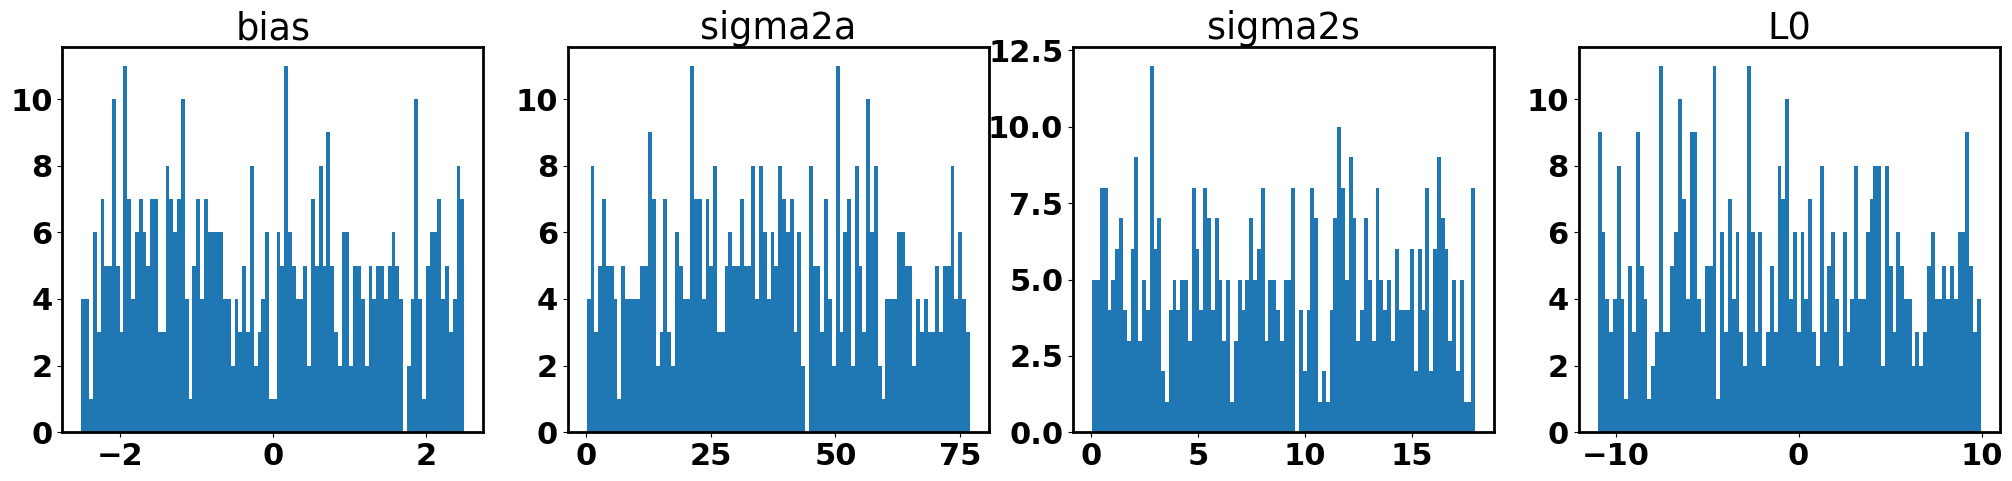

In [13]:
theta = theta_dur_3[0,0,0,:,:]
num_theta = theta.shape[1]
print(f'theta shape: {theta.shape}')
print(f'num_theta: {num_theta}')

prior_min = [-2.5,   0,  0, -11]
prior_max = [ 2.5,  77, 18,  10]
print(f'prior_min: {prior_min}')
print(f'prior_max: {prior_max}')

prior_labels = ['bias', 'sigma2a', 'sigma2s', 'L0']
# plot theta distributions
fig, ax = plt.subplots(1, num_theta, figsize=(25, 5))
for i in range(num_theta):
    ax[i].hist(theta[:,i], bins=100)
    ax[i].set_title(prior_labels[i])
print('sampled prior distributions')

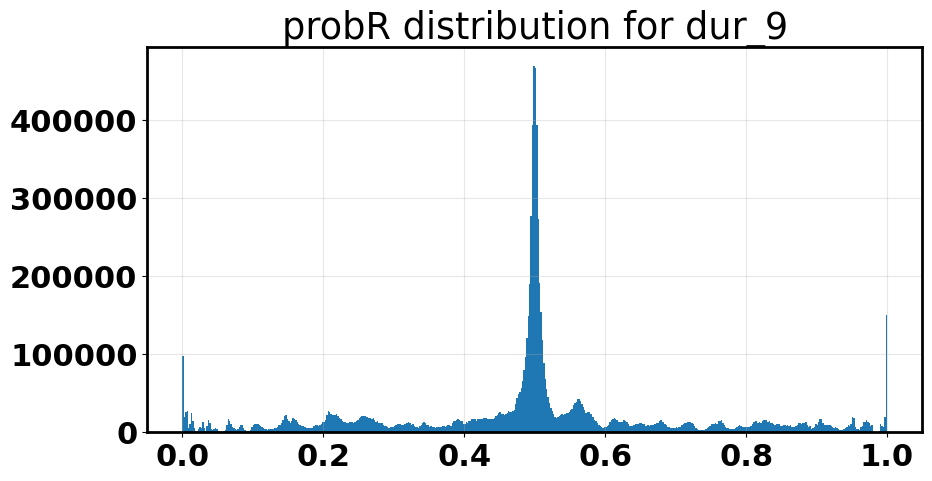

In [63]:
dur = 9
with open(data_dir / f'seqC_combinatorial_probR_dict_dur_{dur}.pkl', 'rb') as f:
    probR = pickle.load(f)[0]

plt.figure(figsize=(10,5))
_ = plt.hist(probR.reshape(-1), bins=500)
plt.title(f'probR distribution for dur_{dur}')
plt.grid(alpha=0.3)

plot the marginal distribution of probR for each parameter </br>

/home/wehe/anaconda3/envs/sbi/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


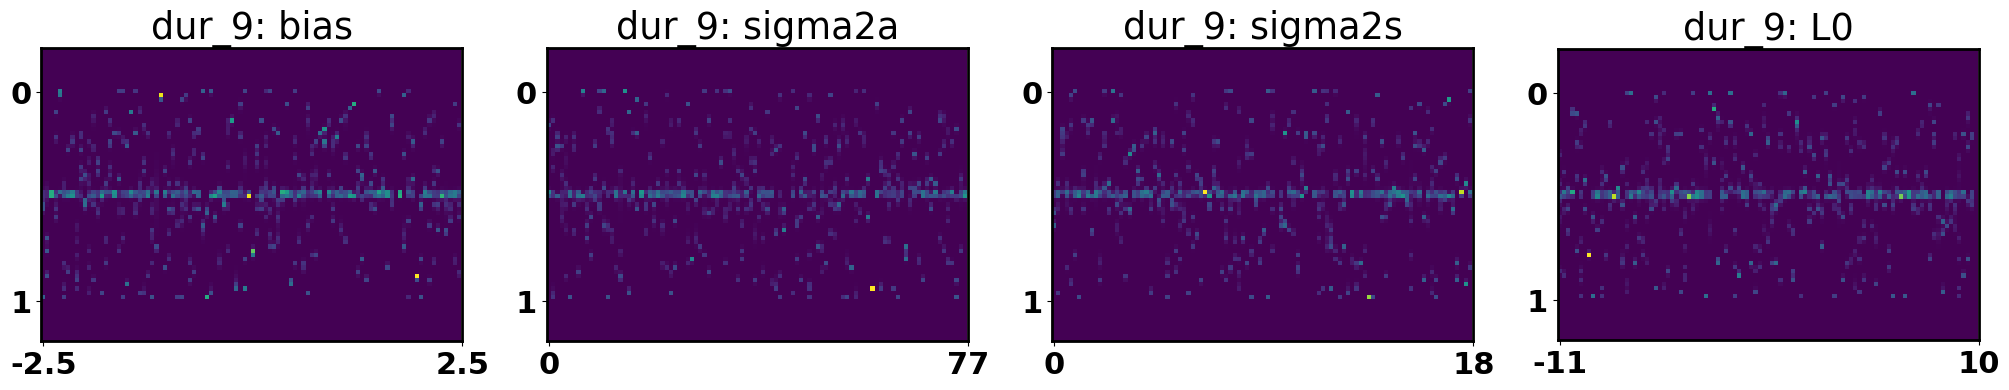

In [64]:
fig, axs = plt.subplots(1,4, figsize=(25, 10))
for k, theta_col_idx in enumerate([0, 1, 2, 3]):

    theta_one_col = theta[:,theta_col_idx]
    theta_range = [prior_min[theta_col_idx], prior_max[theta_col_idx]]
    theta_step = (theta_range[1] - theta_range[0]) / 100
    theta_bin = np.arange(theta_range[0], theta_range[1]+theta_step, theta_step)

    histograms = []
    for i in range(len(theta_bin)-1):
        theta_bin_range = [theta_bin[i], theta_bin[i+1]]
        theta_row_idx_current_bin = np.where((theta_one_col>=theta_bin_range[0]) & (theta_one_col<theta_bin_range[1]))[0]
        probR_masked = probR[:,:,:, theta_row_idx_current_bin,:].reshape(-1)
        histogram, _ = np.histogram(probR_masked, bins=50, range=(0, 1))
        histograms.append(histogram)
    histograms = np.array(histograms)
    histograms = histograms / histograms.sum(axis=1, keepdims=True)
    # avoid the case where the histogram is all zeros
    histograms[np.isnan(histograms)] = 0
    
    offset = 10
    # expand histogram with two more columns with zeros
    histograms = np.concatenate([np.zeros((histograms.shape[0], offset)), histograms, np.zeros((histograms.shape[0], offset))], axis=1)
    
    # ax = axs[k//2][k%2]
    ax = axs[k]
    ax.imshow(histograms.T)
    
    xticklabels=[prior_min[theta_col_idx], prior_max[theta_col_idx]]
    ax.set_xticks([0, len(theta_bin)-1])
    ax.set_xticklabels(xticklabels)
    ax.set_yticks([offset, offset+50])
    ax.set_yticklabels([0, 1])
    ax.set_title(f'dur_{dur}: {prior_labels[theta_col_idx]}')

One concern is that the probR result distribution is not good for training the neural network. </br>
Which can lead to a **overfitting** of the network where the network would produce a distribution that is lead to a 0.5/0/1 probR. </br>

try linear regression on the probR result </br>

In [40]:
theta_2D = np.repeat(theta, axis=0, repeats=3*9)
probR_2D = np.repeat(probR.reshape(-1, 1), axis=1, repeats=4)

In [41]:
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(theta_2D, probR_2D)

ValueError: too many values to unpack (expected 4)